## Generating and visualizing embeddings with DNABert    

<div class="alert alert-block alert-info"> <b>NOTE</b> This notebook was tested on a single RT5880 Ada Generation GPU using BioNeMo Framework v1.8 with an expected runtime of approximately < 20min.</div>

### Demo Objectives

1. **Setup**
    * **Objective:** 
        * Set up the environment and necessary configurations to run the DNABERT model for inference. This includes loading the required libraries, setting up the BioNeMo environment, and ensuring that the DNABERT model is properly loaded.
    * **Steps:**
        1. Import required libraries.
        2. Set up the BioNeMo home directory.
        3. Load the DNABERT model configuration and ensure the model is properly restored from the specified checkpoint.

2. **Data Preparation**
    * **Objective:** 
        * Prepare the input dataset for DNABERT inference, including extracting a specific number of sequences of a fixed length from a Mycobacterium tuberculosis genome.
    * **Steps:**
        1. Download and prepare the Mycobacterium tuberculosis genome data.
        2. Extract all available sequences with a length of at least 512 nucleotides.
        3. Truncate sequences longer than 512 nucleotides and format them into a CSV file for input into DNABERT.

3. **Generating and Visualizing Embeddings, Clustering**
    * **Objective:** 
        * Generate embeddings from the prepared sequences using DNABERT to identify potential patterns in the data.
    * **Steps:**
        1. Run the DNABERT model to generate embeddings for each of the sequences.
        2. Visualize the embeddings in 2D space using Principal Component Analysis (PCA).

#### Relevance: 

Tuberculosis (TB) remains a leading cause of death worldwide, especially in low- and middle-income countries, due to the complex biology of Mycobacterium tuberculosis and its ability to develop drug resistance. The genome assembly ASM19595v2 for Mycobacterium tuberculosis H37Rv, submitted by the Sanger Institute, is a critical reference strain in TB research. This strain is extensively used to study the molecular mechanisms underlying TB infection and drug resistance, making it essential for developing new diagnostic tools, treatments, and vaccines.

By generating embeddings from the DNA sequences of this genome, we can capture important features that may be applied in downstream tasks such as identifying potential drug targets, understanding pathogen variability, and improving diagnostics. This demo illustrates the potential of AI-driven approaches in bioinformatics, showing how deep learning models can extract meaningful insights from genomic data to support advancements in TB research and contribute to global health efforts.

### 1. Setup

Ensure that you have read through the Getting Started section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI) within the container. It is assumed that this notebook is being executed from within the container.

<div class="alert alert-block alert-info" style="padding: 15px; border: 1px solid #cfe2ff; background-color: #e7f3fe; border-radius: 5px;">
    <b>NOTE:</b> Some of the cells below can generate long text output. We're using:
    <pre style="background-color: #f8f9fa; border: 1px solid #dee2e6; padding: 10px; border-radius: 5px;">%%capture --no-display --no-stderr cell_output</pre>
    to suppress this output. Comment or delete this line in the cells below to restore full output.
</div>

### Import and install all required packages

In [97]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from Bio import SeqIO

from bionemo.utils.hydra import load_model_config
from bionemo.model.dna.dnabert.infer import DNABERTInference

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Home Directory

Set the home directory as follows:

In [98]:
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Download Model Checkpoints

The following code will download the pretrained model dnabert-86M.nemo from the NGC registry. 

In [99]:
# Define the NGC CLI API KEY and ORG for the model download
# If these variables are not already set in the container, uncomment below
# to define and set with your API KEY and ORG

#api_key = <YOUR_API_KEY>
#ngc_cli_org = <YOUR_NGC_ORG>
# Update the environment variables 
#os.environ['NGC_CLI_API_KEY'] = api_key
#os.environ['NGC_CLI_ORG'] = ngc_cli_org

In [100]:
# Set variables and paths for model and checkpoint
model_name = "dnabert" 
model_version = "dnabert-86M" 
actual_checkpoint_name = "dnabert-86M.nemo" 
model_path = os.path.join(bionemo_home, 'models')
checkpoint_path = os.path.join(model_path, actual_checkpoint_name)
os.environ['MODEL_PATH'] = model_path

In [106]:
%%capture --no-display --no-stderr cell_output
if not os.path.exists(checkpoint_path):
    !cd /workspace/bionemo && \
    python download_artifacts.py --model_dir models --models {model_name}
else:
    print(f"Model {model_name} already exists at {model_path}.")

### 2. Data Preparation

Next, we need to download the data from the NCBI website and create a BioNeMo compatible data format for inference, which is a CSV file with an `index` column and a column for sequences. For this tutorial, we will be using the genome assembly ASM19595v2 for Mycobacterium tuberculosis H37Rv, which is the NCBI RefSeq assembly GCF_000195955.2. This assembly was submitted by the Sanger Institute on February 1, 2013. As we are not doing training in this demo, we will not need to perform the typical train, validation, and test splits.

#### Download the Mycobacterium tuberculosis data from NCBI 

First, we need to create a directory for the data that will be used in this tutorial. 

In [102]:
base_data_dir = os.path.join(bionemo_home, "data", "mtb_data")

# Checking if the directory exists
if not os.path.exists(base_data_dir):
    os.makedirs(base_data_dir)
    print(f"Created the directory: {base_data_dir}")
else:
    print(f"The directory already exists: {base_data_dir}")

The directory already exists: /workspace/bionemo/data/mtb_data


Download the `datasets` command-line tool from the NCBI website.
This tool is essential for efficiently retrieving and processing genomic data.
The `datasets` tool is used to download various types of biological data, including genomes, genes, and sequences, directly from NCBI.
In this case, we'll use this tool to download the Mycobacterium tuberculosis data from the NCBI database.
The data retrieved can include whole genome sequences, annotations, and other relevant biological information,
which are critical for further analysis, such as sequence alignment, variant calling, and comparative genomics.

In [103]:
!curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/linux-amd64/datasets'
!chmod +x datasets

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.0M  100 22.0M    0     0   638k      0  0:00:35  0:00:35 --:--:--  476k


In [105]:
%%capture --no-display --no-stderr cell_output

# Downloading the dataset directly to the desired directory and name the zip file
!./datasets download genome accession GCF_000195955.2 --include gff3,rna,cds,protein,genome,seq-report --filename {base_data_dir}/ncbi_dataset.zip

# Unzipping the file in the correct directory
!unzip -o {base_data_dir}/ncbi_dataset.zip -d {base_data_dir}

print(f"Extracted the dataset to: {base_data_dir}")

#### Checking the number of sequences in the .fna file  

In [107]:
input_fasta = os.path.join(base_data_dir, "ncbi_dataset", "data", "GCF_000195955.2", "cds_from_genomic.fna")

# Counting the number of sequences in the file
num_sequences = sum(1 for _ in SeqIO.parse(input_fasta, "fasta"))

print(f"Number of sequences in the file: {num_sequences}")

Number of sequences in the file: 3906


#### Converting fasta file to expected CSV format 

Now, we need to convert the fasta file of the sequences to a BioNeMo compatible CSV format, which consists of a column for an index and a column containing sequence strings. 

For DNABERT, the maximum sequence length should be 512 tokens, as the model is based on the BERT architecture, which has this limitation. If any sequences exceed a length of 512 or are less than 512, they need to be truncated to fit within this limit.

In [108]:
# Output CSV file (renamed to sequences_preprocessed.csv to reflect processing)
processed_data_file = os.path.join(base_data_dir, "sequences_preprocessed.csv")

# Setting the maximum sequence length
max_seq_len = 512

# Using SeqIO to parse the sequences and truncate them to 512 nucleotides
sequence_dict = {}
for record in SeqIO.parse(input_fasta, "fasta"):
    truncated_seq = str(record.seq)[:max_seq_len]
    if len(truncated_seq) == max_seq_len:
        sequence_dict[record.id] = truncated_seq

# Creating a DataFrame with original IDs and truncated sequences
df = pd.DataFrame(sequence_dict.items(), columns=['id', 'sequence'])

# Saving the DataFrame to a CSV file after processing
df.to_csv(processed_data_file, index=False)

print(f"Total number of sequences with length {max_seq_len}: {len(df)}")

### 3. Generating and Visualizing Embeddings 

In this section, we will use the DNABERT model to perform inference on our input sequences. By running inference, we’ll generate embeddings, which are dense vector representations of the sequences. These embeddings capture important features of the sequences and can be used for various downstream tasks such as clustering, visualization, or classification.
To give you a comprehensive understanding and flexibility in your workflow, two methods are demonstrated for generating embeddings: using command line arguments and manually calling classes within the code.


In [109]:
model_config_path = os.path.join(bionemo_home, f'examples/dna/dnabert/conf')

Method 1: Generating embeddings through command-line arguments. This approach also allows for easy parameter adjustments, such as specifying output formats or paths, which can be particularly useful in large-scale experiments or production environments. Additionally, for DNABERT, note that we can change the precision configuration from the default mixed-precision (16-bit) to full precision (32-bit).

In [110]:
output_dir = os.path.join(base_data_dir, "inference_output")
! mkdir -p {output_dir}
inference_results = os.path.join(output_dir, "dnabert_inference_results.pkl")

In [111]:
%%capture --no-display --no-stderr cell_output
# This environment variable enables full error traces from Hydra, which can help in debugging by providing comprehensive error information.
# It's particularly useful when the default error messages are too vague to identify the root cause.
# os.environ['HYDRA_FULL_ERROR'] = '1'

# Run the inference script
! python /workspace/bionemo/bionemo/model/infer.py \
    --config-dir {model_config_path} \
    --config-name infer \
    ++name=DNABERT_Inference \
    ++model.downstream_task.restore_path={checkpoint_path} \
    ++model.data.dataset_path={processed_data_file} \
    ++model.inference_output_file={inference_results} \
    ++model.data.output_fname={inference_results} \
    ++model.downstream_task.outputs=[embeddings] \
    ++trainer.precision=32 \
    ++trainer.devices=1 \
    ++exp_manager.exp_dir={output_dir}

Method 2: Generating embeddings by manually calling classes. This method allows for more control over debugging during the embedding generation process.   

In [ ]:
%%capture --no-display --no-stderr cell_output
# Loading the DNABERT model manually 
cfg = load_model_config(config_name="infer.yaml", config_path=model_config_path)
model = DNABERTInference(cfg, interactive=True)
model.to('cuda') 
model.float()  # Ensure model uses float precision

# Processing the sequences
embeddings = []
max_seq_len = 512 

for sequence in df['sequence']:
    if len(sequence) > max_seq_len:
        sequence = sequence[:max_seq_len]
    
    # Tokenizing and generating embeddings
    token_ids = torch.tensor(model.tokenize([sequence]), device=model.model.device).long()
    output, _ = model.seq_to_hiddens([sequence])
    embedding = output.cpu().detach().numpy().flatten()
    
    # Storing the embedding
    embeddings.append(embedding)

# Inspecting the first 5 embeddings
for i, embedding in enumerate(embeddings[:5]):
    print(f"Embedding for sequence {i}: Shape {embedding.shape}, First few values: {embedding[:5]}")


### Visualizing Embeddings

In this section, we visualize the embeddings generated from the DNA sequences using PCA.

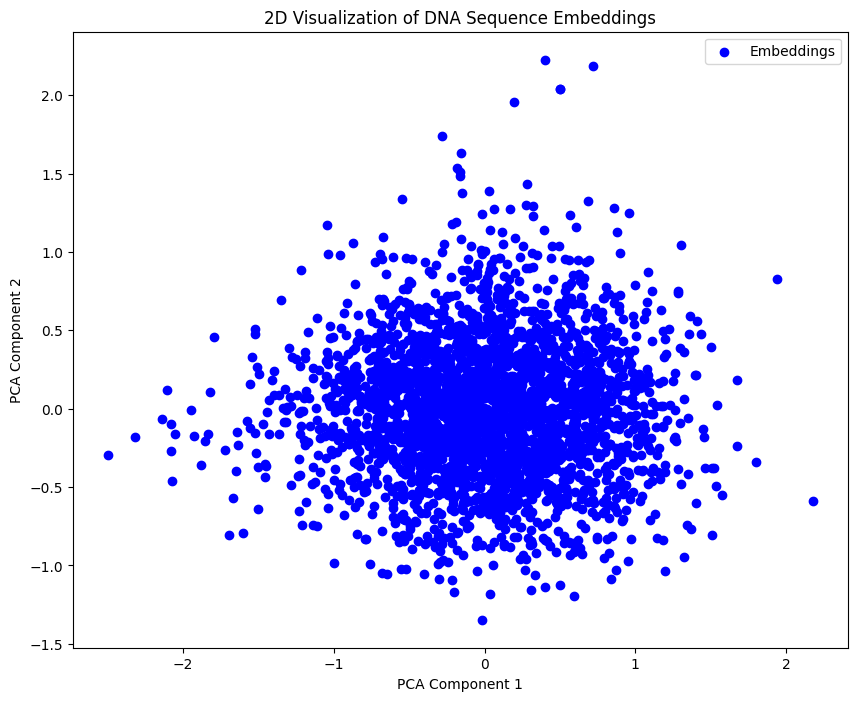

In [113]:
with open(inference_results, "rb") as f:
    inference_results_to_plot = pickle.load(f)

# Extracting embeddings from each dictionary in the list
embeddings = np.array([item['embeddings'] for item in inference_results_to_plot])

# Performing PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='b', label="Embeddings")

plt.title('2D Visualization of DNA Sequence Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In this tutorial, you set up the DNABERT model for inference, prepared a dataset by extracting specific sequences from the Mycobacterium tuberculosis genome, and generated embeddings using DNABERT. These embeddings were then visualized. 